In [1]:
"""
use time to cut sequences
command 
python main_time.py --data_folder ../Data/xing/ --train_data train_item.pickle --valid_data test_item.pickle --test_data test_item.pickle --data_name xing --embedding_dim 300 --hidden_size 300 --lr 0.005
"""
import argparse
import torch
# import lib
import numpy as np
import os
import datetime
from loss import *
from network import *
from optimizer import *
from trainer import *
from torch.utils import data
import pickle
import sys
from dataset_time import *
# from data_time import *
from logger import *
import collections

import sys
sys.path.insert(0, '../../PyTorch_GBW_LM')
sys.path.insert(0, '../../PyTorch_GBW_LM/log_uniform')

from sampledSoftmax import *

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--hidden_size', default=50, type=int)
parser.add_argument('--num_layers', default=1, type=int)
parser.add_argument('--batch_size', default=100, type=int)
parser.add_argument('--dropout_input', default=0, type=float)
parser.add_argument('--dropout_hidden', default=.2, type=float)

# parse the optimizer arguments
parser.add_argument('--optimizer_type', default='Adagrad', type=str)
parser.add_argument('--final_act', default='tanh', type=str)
parser.add_argument('--lr', default=.05, type=float)
parser.add_argument('--weight_decay', default=0.0, type=float)
parser.add_argument('--momentum', default=0.1, type=float)
parser.add_argument('--eps', default=1e-6, type=float)

parser.add_argument("-seed", type=int, default=7,
                     help="Seed for random initialization")
parser.add_argument("-sigma", type=float, default=None,
                     help="init weight -1: range [-sigma, sigma], -2: range [0, sigma]")
parser.add_argument("--embedding_dim", type=int, default=-1,
                     help="using embedding")
# parse the loss type
parser.add_argument('--loss_type', default='TOP1', type=str)
# parser.add_argument('--loss_type', default='BPR', type=str)
parser.add_argument('--topk', default=5, type=int)
# etc
parser.add_argument('--bptt', default=1, type=int)
parser.add_argument('--test_observed', default=5, type=int)
parser.add_argument('--window_size', default=30, type=int)
parser.add_argument('--warm_start', default=5, type=int)

parser.add_argument('--n_epochs', default=20, type=int)
parser.add_argument('--time_sort', default=False, type=bool)
parser.add_argument('--save_dir', default='models', type=str)
parser.add_argument('--data_folder', default='../Data/movielen/1m/', type=str)
parser.add_argument('--data_action', default='item.pickle', type=str)
parser.add_argument('--data_cate', default='cate.pickle', type=str)
parser.add_argument('--data_time', default='time.pickle', type=str)
parser.add_argument("--is_eval", action='store_true')
parser.add_argument('--load_model', default=None,  type=str)
parser.add_argument('--checkpoint_dir', type=str, default='checkpoint')
parser.add_argument('--data_name', default=None, type=str)
parser.add_argument('--shared_embedding', default=None, type=int)
parser.add_argument('--patience', default=1000)
parser.add_argument('--negative_num', default=1000, type=int)
parser.add_argument('--valid_start_time', default=0, type=int)
parser.add_argument('--test_start_time', default=0, type=int)
parser.add_argument('--model_name', default="samplePaddingSessionRNN", type=str)

# Get the arguments
args = parser.parse_args([])
args.cuda = torch.cuda.is_available()

In [4]:
# CUDA_VISIBLE_DEVICES=0 python eval_main_time.py --data_folder ../Data/tmall/100k_unknown_cate/ 
# --data_action item_time.pickle --data_cate cate_time.pickle --data_time time_time.pickle 
# --data_name taobao --embedding_dim 300 --hidden_size 300 --lr 0.001 --window_size 20 
# --test_observed 5 --n_epochs 100 --shared_embedding 1 --batch_size 300 
# --optimizer_type Adam --loss_type 'XE' --valid_start_time 1512172800 --test_start_time 1512259200 
# --negative_num 10000 --topk 20 --checkpoint_dir "../log/samplePaddingSessionRNN/checkpoint/01022149"


In [5]:
args.data_folder = "../../../Data/tmall/100k_unknown_cate/"
args.data_action = "item_time.pickle"
args.data_cate = "cate_time.pickle"
args.data_time = "time_time.pickle"
args.data_name = "taobao"
args.embedding_dim = 256
args.hidden_size = 256
args.lr = 0.001
args.window_size = 20
args.test_observed = 5
args.n_epochs = 100
args.shared_embedding = 1
args.batch_size = 256
args.optimizer_type = "Adam"
args.loss_type = "XE"
args.valid_start_time = 1512172800
args.test_start_time = 1512259200
args.negative_num = 10000
args.topk = 20
args.checkpoint_dir = "../../log/samplePaddingSessionRNN/checkpoint/01031151"

In [6]:
np.random.seed(args.seed)
torch.manual_seed(7)
random.seed(args.seed)

if args.cuda:
    print("gpu")
    torch.cuda.manual_seed(args.seed)
else:
    print("cpu")

gpu


In [7]:
# 1512172800: 12/02/2017 @ 12:00am (UTC)
### 1512187200: 12/02/2017 @ 4:00am (UTC)
## 1512201600: 12/02/2017 @ 8:00am (UTC)
### 1512216000: 12/02/2017 @ 12:00pm (UTC)
### 1512230400: 12/02/2017 @ 4:00pm (UTC)
### 1512244800: 12/02/2017 @ 8:00pm (UTC)
# 1512259200: 12/03/2017 @ 12:00am (UTC)

In [8]:
def make_checkpoint_dir(log):
    print("PARAMETER" + "-"*10)
    now = datetime.datetime.now()
    S = '{:02d}{:02d}{:02d}{:02d}'.format(now.month, now.day, now.hour, now.minute)
    checkpoint_dir = "../log/"+args.model_name+"/"+args.checkpoint_dir
    args.checkpoint_dir = checkpoint_dir
    save_dir = os.path.join(args.checkpoint_dir, S)

    if not os.path.exists("../log"):
        os.mkdir("../log")
    
    if not os.path.exists("../log/"+args.model_name):
        os.mkdir("../log/"+args.model_name)

    if not os.path.exists(args.checkpoint_dir):
        os.mkdir(args.checkpoint_dir)

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    args.checkpoint_dir = save_dir
    
    with open(os.path.join(args.checkpoint_dir, 'parameter.txt'), 'w') as f:
        for attr, value in sorted(args.__dict__.items()):
            msg = "{}={}".format(attr.upper(), value)
            log.addOutput2IO(msg)
            f.write("{}={}\n".format(attr.upper(), value))

    msg = "---------" + "-"*10
    log.addOutput2IO(msg)

def load_args(model_path):
    model_file = os.path.join(model_path, "model_best.pt")
    print("args file load", model_file)
    check_point = torch.load(model_file, map_location=torch.device('cpu'))
    args = check_point['args']

def load_model(network, model_path):
    print("reload model")
    model_file = os.path.join(model_path, "model_best.pt")
    print("model file", model_file)
    check_point = torch.load(model_file)

    network.load_state_dict(check_point['model'])

def count_parameters(model):
    parameter_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("parameter_num", parameter_num) 


In [9]:
model_path = args.checkpoint_dir
load_args(model_path)

BPTT = args.bptt

device = torch.device('cuda' if args.cuda else 'cpu')
print("device", device)

if args.embedding_dim == -1:
    raise AssertionError()

data_name = args.data_name

print("*"*10+"train load"+"*"*10)

observed_threshold = args.test_observed

data_action = args.data_folder+args.data_action
data_cate = args.data_folder+args.data_cate
data_time = args.data_folder+args.data_time

valid_start_time = args.valid_start_time
test_start_time = args.test_start_time

st = datetime.datetime.now()
data_obj = MYDATA(data_action, data_cate, data_time, valid_start_time, test_start_time, observed_threshold, args.window_size)
et = datetime.datetime.now()
print("load data duration ", et-st)

train_data = data_obj.train_dataset
valid_data = data_obj.test_dataset
test_data = data_obj.test_dataset

print("+"*10+"valid load"+"+"*10)

input_size = data_obj.items()
output_size = input_size

negative_num = args.negative_num

train_data_loader = MYDATALOADER(train_data, args.batch_size)
valid_data_loader = MYDATALOADER(valid_data, args.batch_size)
test_data_loader = MYDATALOADER(valid_data, args.batch_size)

ss = SampledSoftmax(output_size, negative_num, args.embedding_dim, None)

network = NETWORK(input_size, ss, args, device)
load_model(network, model_path)

### eval
loss_function = LossFunction(device, loss_type=args.loss_type)

topk = args.topk
eval = Evaluation(None, network, loss_function, device, topk, args.warm_start)

args file load ../../log/samplePaddingSessionRNN/checkpoint/01031151/model_best.pt
device cuda
**********train load**********
action seq num 51275
time seq num 51275
loading item map
loading item map
observed_threshold 5 20
loading data
valid_start_time 1512172800
test start time 1512259200
seq num for training 2738883
seq num of actions for training 2738883
seq num for testing 430797
seq num of actions for testing 430797
load data duration  0:00:09.228104
++++++++++valid load++++++++++
item num 68008
seq num 2738883
batch size 256
batch_num 10698
seq num 430797
batch size 256
batch_num 1682
seq num 430797
batch size 256
batch_num 1682


/u/sr3hd/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


reload model
model file ../../log/samplePaddingSessionRNN/checkpoint/01031151/model_best.pt


### get time id

In [10]:
# 1512172800: 12/02/2017 @ 12:00am (UTC)
### 1512187200: 12/02/2017 @ 4:00am (UTC)
## 1512201600: 12/02/2017 @ 8:00am (UTC)
### 1512216000: 12/02/2017 @ 12:00pm (UTC)
### 1512230400: 12/02/2017 @ 4:00pm (UTC)
### 1512244800: 12/02/2017 @ 8:00pm (UTC)
# 1512259200: 12/03/2017 @ 12:00am (UTC)

In [11]:
def get_timeid(time):
    time_threshold_list = [1512172800, 1512187200, 1512201600, 1512216000, 1512230400, 1512244800, 1512259200]
#     print("time threshold num", len(time_threshold_list))
    
    timeid = 0
    
    if time <= time_threshold_list[1]:
        timeid = 1
    elif time <= time_threshold_list[2]:
        timeid = 2
    elif time <= time_threshold_list[3]:
        timeid = 3
    elif time <= time_threshold_list[4]:
        timeid = 4
    elif time <= time_threshold_list[5]:
        timeid = 5
    else:
        timeid = 6
        
    return timeid

In [12]:
# time_item_freq_dict = {}
# time_bucket_recall_dict = {}
# time_bucket_mrr_dict = {}

In [13]:
def bias_eval(eval_data):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = args.topk
    
    ### time: item: [recall]
    time_item_recall_dict = {}
    time_item_mrr_dict = {}
    time_item_pred_dict = {} # Number of times item is predicted in each time interval

    
### t_y_batch: time of y action
    
    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in dataloader:
            
            x_short_action_batch = x_short_action_batch.to(device)
            mask_short_action_batch = mask_short_action_batch.to(device)
            y_action_batch = y_action_batch.to(device)

            # warm_start_mask = (y_action_idx_batch>=self.warm_start)

            output_batch = network(x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch)

            sampled_logit_batch, sampled_target_batch = network.m_ss(output_batch, y_action_batch, \
                                                        None, None, None, None, None, None, "full")

            loss_batch = loss_function(sampled_logit_batch, sampled_target_batch)
            losses.append(loss_batch.item())

            _, preds = torch.topk(sampled_logit_batch, topk, -1)
            preds = preds.cpu()
            targets = sampled_target_batch.cpu()

            expand_targets = targets.view(-1, 1).expand_as(preds)
            hits = (preds == expand_targets)

            for i, hit in enumerate(hits):
                target_i = targets[i]
                itemid_i = target_i.item()
                time_i = t_y_batch[i].item()
                timeid = get_timeid(time_i)
                
                if timeid not in time_item_recall_dict:
                    time_item_recall_dict[timeid] = {}
                    time_item_mrr_dict[timeid] = {}
                if itemid_i not in time_item_recall_dict[timeid]:
                    time_item_recall_dict[timeid][itemid_i] = []
                    time_item_mrr_dict[timeid][itemid_i] = []
                
                rank = hit.nonzero()
                
                if len(rank) == 1:
                    time_item_recall_dict[timeid][itemid_i].append(1.0)
                    rank = rank[0]+1.0
                    rank = torch.reciprocal(rank.float())
                    time_item_mrr_dict[timeid][itemid_i].append(rank.item())
                else:
                    time_item_recall_dict[timeid][itemid_i].append(0.0)
                    time_item_mrr_dict[timeid][itemid_i].append(0.0)
                    
            for seq_num in range(len(preds)):
                for pred in preds[seq_num]:
                    item_id = pred.item()
                    target_id = targets[seq_num].item()
                    time_i = t_y_batch[seq_num].item()
                    timeid = get_timeid(time_i)
                
                    if timeid not in time_item_pred_dict:
                        time_item_pred_dict[timeid] = {}
                    if item_id not in time_item_pred_dict[timeid]:
                        time_item_pred_dict[timeid][item_id] = []
                    if item_id == target_id:
                        time_item_pred_dict[timeid][item_id].append(1.0)
                    else:
                        time_item_pred_dict[timeid][item_id].append(0.0)
                    
                
            total_test_num.append(y_action_batch.view(-1).size(0))
            
    return time_item_recall_dict, time_item_mrr_dict, time_item_pred_dict
    

In [14]:
def get_time_item_freq(eval_data, time_item_freq_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = args.topk
    
    ### time: item: freq
    
    ### t_action_batch: time of y action
    
    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in dataloader:
            batch_size = y_action_batch.size(0)
            for seq_index in range(batch_size):
                y_i = y_action_batch[seq_index]
                t_i = t_y_batch[seq_index]
                item_i = y_i.item()
                time_id = get_timeid(t_i.item())
                
                if time_id not in time_item_freq_dict:
                    time_item_freq_dict[time_id] = {}
                if item_i not in time_item_freq_dict[time_id]:
                    time_item_freq_dict[time_id][item_i] = 0.0
                time_item_freq_dict[time_id][item_i] += 1.0
        
        for time in sorted(list(time_item_freq_dict.keys())):
            if time > 1:
                for item in time_item_freq_dict[time-1]:
                    if item not in time_item_freq_dict[time]:
                        time_item_freq_dict[time][item] = 0.0
                    time_item_freq_dict[time][item] += time_item_freq_dict[time-1][item]
#     return time_item_freq_dict

In [15]:
def get_item_freq(eval_data, item_freq_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = args.topk
    
    ### time: item: freq
    
    ### t_action_batch: time of y action
    
    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in dataloader:
            batch_size = y_action_batch.size(0)
            for seq_index in range(batch_size):
                y_i = y_action_batch[seq_index]
                t_i = t_y_batch[seq_index]
                item_i = y_i.item()
                
                if item_i not in item_freq_dict:
                    item_freq_dict[item_i] = 0.0
                item_freq_dict[item_i] += 1.0

In [16]:
def load_train_freq(time_item_freq_dict, item_freq_dict):
    for time in time_item_freq_dict:
        item_freq_dict_time = time_item_freq_dict[time]
        
        for item in item_freq_dict:
            if item not in item_freq_dict_time:
                item_freq_dict_time[item] = 0.0
            item_freq_dict_time[item] += item_freq_dict[item]
    
    time_item_freq_dict[0] = {}
    for item in item_freq_dict:
        time_item_freq_dict[0][item] = item_freq_dict[item]
        

In [65]:
def get_topk_ngrams(train_data, eval_data, ngram_freq_dict):
    network.eval()
    
    train_dataloader = train_data
    eval_dataloader = eval_data
    topk = args.topk
    ngram_sizes = [4]
    
    with torch.no_grad():
    
        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in train_dataloader:
            for seq_index, seq in enumerate(x_short_action_batch):
                y_i = y_action_batch[seq_index]
                t_i = t_y_batch[seq_index]
                item_i = y_i.item()
                time_id = get_timeid(t_i.item())
                
                for size in ngram_sizes:
                    for item_index in range(len(seq)-size+1):
                        y_i = seq[item_index:item_index+size]
                        ngram = tuple([y.item() for y in y_i])
                        
                        if 0 in ngram:
                            continue
                            
                        if time_id not in ngram_freq_dict:
                            ngram_freq_dict[time_id] = {}
                        if ngram not in ngram_freq_dict[time_id]:
                            ngram_freq_dict[time_id][ngram] = 0
                        ngram_freq_dict[time_id][ngram] += 1
            
        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in eval_dataloader:
            for seq_index, seq in enumerate(x_short_action_batch):
                y_i = y_action_batch[seq_index]
                t_i = t_y_batch[seq_index]
                item_i = y_i.item()
                time_id = get_timeid(t_i.item())
                
                for size in ngram_sizes:
                    for item_index in range(len(seq)-size+1):
                        y_i = seq[item_index:item_index+size]
                        ngram = tuple([y.item() for y in y_i])
                        
                        if 0 in ngram:
                            continue
                            
                        if time_id not in ngram_freq_dict:
                            ngram_freq_dict[time_id] = {}
                        if ngram not in ngram_freq_dict[time_id]:
                            ngram_freq_dict[time_id][ngram] = 0
                        ngram_freq_dict[time_id][ngram] += 1

In [66]:
def is_subseq(seq, ngram):
    size = len(ngram)
    indices = [i for i in range(len(seq)) if tuple(seq[i:min(i+size, len(seq))]) == ngram]
    return indices

def get_ngram_next_distributions(train_data, eval_data, top_ngrams_all, ngram_next_dist_dict):
    network.eval()
    
    train_dataloader = train_data
    eval_dataloader = eval_data
    
    with torch.no_grad():

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in train_dataloader:
            for seq_index, seq in enumerate(x_short_action_batch):
                y_i = y_action_batch[seq_index]
                t_i = t_y_batch[seq_index]
                item_i = y_i.item()
                time_id = get_timeid(t_i.item())
                seq = tuple([x.item() for x in seq])
                next_item = y_i.item()
                for ngram in top_ngrams_all:
                    indices = is_subseq(seq, ngram)
                    if len(indices) > 0:
                        for idx in indices:
                            if (idx+len(ngram)) < len(seq) and seq[idx+len(ngram)] != 0:
                                next_item = seq[idx+len(ngram)]
                            if time_id not in ngram_next_dist_dict:
                                ngram_next_dist_dict[time_id] = {}
                            if ngram not in ngram_next_dist_dict[time_id]:
                                ngram_next_dist_dict[time_id][ngram] = {}
                            if next_item not in ngram_next_dist_dict[time_id][ngram]:
                                ngram_next_dist_dict[time_id][ngram][next_item] = 0
                            ngram_next_dist_dict[time_id][ngram][next_item] += 1

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in eval_dataloader:
            for seq_index, seq in enumerate(x_short_action_batch):
                y_i = y_action_batch[seq_index]
                t_i = t_y_batch[seq_index]
                item_i = y_i.item()
                time_id = get_timeid(t_i.item())
                seq = tuple([x.item() for x in seq])
                next_item = y_i.item()
                for ngram in top_ngrams_all:
                    indices = is_subseq(seq, ngram)
                    if len(indices) > 0:
                        for idx in indices:
                            if (idx+len(ngram)) < len(seq) and seq[idx+len(ngram)] != 0:
                                next_item = seq[idx+len(ngram)]
                            if time_id not in ngram_next_dist_dict:
                                ngram_next_dist_dict[time_id] = {}
                            if ngram not in ngram_next_dist_dict[time_id]:
                                ngram_next_dist_dict[time_id][ngram] = {}
                            if next_item not in ngram_next_dist_dict[time_id][ngram]:
                                ngram_next_dist_dict[time_id][ngram][next_item] = 0
                            ngram_next_dist_dict[time_id][ngram][next_item] += 1

In [67]:
train_item_freq_dict = {}
#get_item_freq(train_data_loader, train_item_freq_dict)

In [68]:
time_item_freq_dict = {}
get_time_item_freq(test_data_loader, time_item_freq_dict)

shuffling


In [69]:
load_train_freq(time_item_freq_dict, train_item_freq_dict)

In [70]:
ngram_freq_dict = {}
get_topk_ngrams(train_data_loader, test_data_loader, ngram_freq_dict)
print(ngram_freq_dict.keys())

shuffling
shuffling
dict_keys([1, 4, 5, 6, 2, 3])


In [71]:
topk = 10
top_ngrams = [] #stores last time's topk ngrams
top_ngrams_time = {}
top_ngrams_all = []
for time in sorted(ngram_freq_dict.keys()):
    print("-----------",time,"------------")
    ngrams_val_past = 0
    if time-1 in ngram_freq_dict:
        ngrams_val_past = sorted(list(ngram_freq_dict[time-1].values()), reverse=True)
    ngrams_val = sorted(list(ngram_freq_dict[time].values()), reverse=True)
    # Rankings of previous topk n-grams
    print("previous topk n-grams:")
    k = 1
    for ngram in top_ngrams:
        ranking = 0 # 0 if ngram doesn't appear in this time period
        if ngram in ngram_freq_dict[time]:
            ranking = ngrams_val.index(ngram_freq_dict[time][ngram]) + 1
        print("%d."%(k), ngram, "current rank:", ranking)
        
        k+=1
    
    top_ngrams = []
    print("current topk n-grams:")
    k = 1
    ngrams = list(ngram_freq_dict[time].keys())
    for val in ngrams_val:
        ranking = 0
        ngram_idx = list(ngram_freq_dict[time].values()).index(val)
        ngram = ngrams[ngram_idx]
        if (ngram in top_ngrams) or (0 in ngram):
            continue
            
        if time-1 in ngram_freq_dict:
            if ngram in ngram_freq_dict[time-1]:
                ranking = ngrams_val_past.index(ngram_freq_dict[time-1][ngram]) + 1
            print("%d."%(k), ngram, "previous rank:", ranking)
        else:
            print("%d."%(k), ngram, "popularity:", val)
        
        top_ngrams.append(ngram)
        
        if k==topk:
            break
        k+=1
    
    if time not in top_ngrams_time:
        top_ngrams_time[time] = []
    top_ngrams_time[time] = top_ngrams

for time in top_ngrams_time:
    for ngram in top_ngrams_time[time]:
        if ngram not in top_ngrams_all:
            top_ngrams_all.append(ngram)
print(top_ngrams_all)

----------- 1 ------------
previous topk n-grams:
current topk n-grams:
1. (12, 16, 17, 12) popularity: 3272
2. (16, 17, 12, 16) popularity: 3010
3. (17, 12, 16, 17) popularity: 2824
4. (11387, 11532, 11387, 11532) popularity: 901
5. (11532, 11387, 11532, 11387) popularity: 884
6. (17749, 17376, 17749, 17376) popularity: 718
7. (17376, 17749, 17376, 17749) popularity: 706
8. (3744, 3744, 3744, 3744) popularity: 646
9. (15381, 18714, 15381, 18714) popularity: 614
10. (18714, 15381, 18714, 15381) popularity: 607
----------- 2 ------------
previous topk n-grams:
1. (12, 16, 17, 12) current rank: 3
2. (16, 17, 12, 16) current rank: 2
3. (17, 12, 16, 17) current rank: 1
4. (11387, 11532, 11387, 11532) current rank: 0
5. (11532, 11387, 11532, 11387) current rank: 0
6. (17749, 17376, 17749, 17376) current rank: 0
7. (17376, 17749, 17376, 17749) current rank: 0
8. (3744, 3744, 3744, 3744) current rank: 0
9. (15381, 18714, 15381, 18714) current rank: 11831
10. (18714, 15381, 18714, 15381) curre

In [72]:
ngram_next_dist_dict = {} # {time : {ngram : {next_item : 0}}}
get_ngram_next_distributions(train_data_loader, test_data_loader, top_ngrams_all, ngram_next_dist_dict)

shuffling
shuffling


In [73]:
time_ngram_prob = {}
totals = {}
for time in sorted(ngram_next_dist_dict.keys()):
    print("-----------",time,"------------")
    num_ngrams_time = len(ngram_freq_dict[time])
    if time not in time_ngram_prob:
        time_ngram_prob[time] = {}
    for ngram in top_ngrams_all:
        if ngram in ngram_next_dist_dict[time]:
            print(ngram)
            next_items = []
            freqs = []
            if ngram not in time_ngram_prob[time]:
                time_ngram_prob[time][ngram] = {}
                for item in ngram_next_dist_dict[time][ngram]:
                    item_freq = ngram_next_dist_dict[time][ngram][item]
                    next_items.append(item)
                    freqs.append(item_freq)

            total = np.sum(freqs)
            if ngram not in totals:
                totals[ngram] = total

            for i in range(len(freqs)):
                freqs[i] = (freqs[i] + 1/num_ngrams_time) / total
                if next_items[i] not in time_ngram_prob[time][ngram]:
                    time_ngram_prob[time][ngram][next_items[i]] = 0.0
                time_ngram_prob[time][ngram][next_items[i]] = freqs[i]

                print(next_items[i], "probability:", freqs[i])               

----------- 1 ------------
(12, 16, 17, 12)
16 probability: 0.9648533008412155
10407 probability: 0.005195599129723966
5973 probability: 0.005195599129723966
3013 probability: 0.005195599129723966
1356 probability: 0.005195599129723966
1034 probability: 0.0018337409390149198
1623 probability: 0.0018337409390149198
20488 probability: 0.0033618582984281226
1498 probability: 0.005195599129723966
66443 probability: 0.0009168705233669981
64607 probability: 0.0012224939952496386
(16, 17, 12, 16)
17 probability: 0.9102990034393544
16 probability: 0.08039867121344081
12 probability: 0.007973422044005588
188 probability: 0.001328903771580338
(17, 12, 16, 17)
39978 probability: 0.0035410766120597794
57324 probability: 0.005665722504411055
49446 probability: 0.005665722504411055
53657 probability: 0.0021246460171589297
17 probability: 0.08002832873670568
7816 probability: 0.0028328613146093545
7504 probability: 0.005665722504411055
63945 probability: 0.005665722504411055
62250 probability: 0.0056

In [74]:
def kl_divergence(p, q):
    div_sum = 0
    for i in range(len(p)):
        div_sum += (p[i] * math.log(p[i]/q[i])) + (q[i] * math.log(q[i]/p[i]))
    return div_sum

for time in sorted(top_ngrams_time.keys()):
    print("-----------",time,"------------")
    for ngram in top_ngrams_time[time]:
        if time+1 <= max(top_ngrams_time.keys()) and ngram in time_ngram_prob[time+1]:
            t_dist_items = list(time_ngram_prob[time][ngram].keys())
            t1_dist_items = list(time_ngram_prob[time+1][ngram].keys())
            
            larger_dist = time_ngram_prob[time][ngram]
            smaller_dist = time_ngram_prob[time+1][ngram]
            if len(t_dist_items) < len(t1_dist_items):
                larger_dist = time_ngram_prob[time+1][ngram]
                smaller_dist = time_ngram_prob[time][ngram]
            
            p = []
            q = []
            for item in larger_dist:
                if item in smaller_dist:
                    p.append(smaller_dist[item])
                    q.append(larger_dist[item])
                else:
                    p.append((1/num_ngrams_time) / totals[ngram])
                    q.append(larger_dist[item])
            
            for item in smaller_dist:
                if item not in larger_dist:
                    p.append(smaller_dist[item])
                    q.append((1/num_ngrams_time) / totals[ngram])
                
                    
            divergence = kl_divergence(p, q)
            print(ngram, "KL-divergence:", divergence)
        else:
            print(ngram, "doesn't appear in T+1")

----------- 1 ------------
(12, 16, 17, 12) KL-divergence: 0.50109916410209
(16, 17, 12, 16) KL-divergence: 1.4009654350702971
(17, 12, 16, 17) KL-divergence: 14.279161567307478
(11387, 11532, 11387, 11532) doesn't appear in T+1
(11532, 11387, 11532, 11387) doesn't appear in T+1
(17749, 17376, 17749, 17376) doesn't appear in T+1
(17376, 17749, 17376, 17749) doesn't appear in T+1
(3744, 3744, 3744, 3744) doesn't appear in T+1
(15381, 18714, 15381, 18714) KL-divergence: 3.941292134466e-14
(18714, 15381, 18714, 15381) KL-divergence: 0.1744833180979074
----------- 2 ------------
(17, 12, 16, 17) KL-divergence: 22.407827628423732
(16, 17, 12, 16) KL-divergence: 0.00010003739667852887
(12, 16, 17, 12) KL-divergence: 0.5062667400945343
(36658, 36658, 36658, 36658) KL-divergence: 0.1442261902040023
(347, 16903, 347, 16903) doesn't appear in T+1
(16903, 347, 16903, 347) doesn't appear in T+1
(41919, 41919, 41919, 41919) KL-divergence: 1.804526112616883
(51063, 51063, 51063, 51063) KL-divergence

In [27]:
def set_bucket4item(time_item_freq_dict):
#     item_freq_dict = dict(Counter(data.m_y_action))
#     print(len(item_freq_dict))
#     freq_list = list(item_freq_dict.values())
#     print(min(freq_list), max(freq_list))
#     freq_threshold_list = [0, 20, 80, 150, 200, 250, 300, 350]
    
    ### set bucket for each item in a time period
    
    time_itemid_bucketid_dict = {}
    time_bucketid_itemidlist_dict = {}
    time_bucket_freq_dict = {}
    
    sorted_time_list = sorted(list(time_item_freq_dict.keys()))
    for time in sorted_time_list:
        print("=="*10+str(time)+"=="*10)
        if time not in time_itemid_bucketid_dict:
            time_itemid_bucketid_dict[time] = {}
        if time not in time_bucketid_itemidlist_dict:
            time_bucketid_itemidlist_dict[time] = {}
        
        bucket_freq_dict_time = set_bucket4item_time_cluster(time_item_freq_dict[time], time_itemid_bucketid_dict[time], time_bucketid_itemidlist_dict[time])
        #bucket_freq_dict_time = set_bucket4item_time(time_item_freq_dict[time], time_itemid_bucketid_dict[time], time_bucketid_itemidlist_dict[time])
        time_bucket_freq_dict[time] = bucket_freq_dict_time
                
    return time_itemid_bucketid_dict, time_bucketid_itemidlist_dict, time_bucket_freq_dict

In [28]:
def set_bucket4item_time(item_freq_dict_time, itemid_bucketid_dict_time, bucketid_itemidlist_dict_time):
    freq_threshold_list = [0, 20, 30, 40, 80, 120, 240, 400]
    bucket_freq_dict_time = {}
    for itemid in item_freq_dict_time:
        i = item_freq_dict_time[itemid]
        bucketid = 0
        if i <= freq_threshold_list[1]:
            bucketid = 1
        elif i <= freq_threshold_list[2]:
            bucketid = 2
        elif i <= freq_threshold_list[3]:
            bucketid = 3
        elif i <= freq_threshold_list[4]:
            bucketid = 4
        elif i <= freq_threshold_list[5]:
            bucketid = 5
        elif i <= freq_threshold_list[6]:
            bucketid = 6
        elif i <= freq_threshold_list[7]:
            bucketid = 7
        else:
            bucketid = 8
            
        itemid_bucketid_dict_time[itemid] = bucketid
        if bucketid not in bucketid_itemidlist_dict_time:
            bucketid_itemidlist_dict_time[bucketid] = []
        bucketid_itemidlist_dict_time[bucketid].append(itemid)
        
    print("bucket", len(bucketid_itemidlist_dict_time), bucketid_itemidlist_dict_time.keys())
#     for bucketid in bucketid_itemidlist_dict:
    for bucketid in range(1, len(bucketid_itemidlist_dict_time)+1):
        itemid_list_bucket = bucketid_itemidlist_dict_time[bucketid]
        freq_bucket = 0
        for itemid in itemid_list_bucket:
            freq_bucket += item_freq_dict_time[itemid]
        bucket_freq_dict_time[bucketid] = freq_bucket
        print("bucket %d, freq: %d, item num: %d"%(bucketid, freq_bucket, len(itemid_list_bucket)))
#     print("++"*20)
    return bucket_freq_dict_time

In [29]:
from sklearn.cluster import KMeans
def set_bucket4item_time_cluster(item_freq_dict_time, itemid_bucketid_dict_time, bucketid_itemidlist_dict_time):
    num_clusters = 10
    bucket_freq_dict_time = {}
    cluster_pops = {}
    popularities = np.array(list(item_freq_dict_time.values()))
    if len(popularities) > 0:
        clusters = KMeans(num_clusters)
        labels = clusters.fit_predict(popularities.reshape(-1, 1))
        centroids = clusters.cluster_centers_
        sorted_centroids = sorted(centroids)
        sorted_clusters = [] #Cluster number at position of magnitude, least to greatest
        for num in range(num_clusters):
            i = np.where(centroids == sorted_centroids[num]) # Gives original cluster number
            sorted_clusters.append(i[0][0])
        
        for i, label in enumerate(labels):
            if label not in cluster_pops:
                cluster_pops[label] = []
            cluster_pops[label].append(popularities[i])
            
            label = sorted_clusters.index(label) + 1
            itemid = list(item_freq_dict_time.keys())[i]
            itemid_bucketid_dict_time[itemid] = label
            if label not in bucketid_itemidlist_dict_time:
                bucketid_itemidlist_dict_time[label] = []
            bucketid_itemidlist_dict_time[label].append(itemid)

            
        print("bucket", len(bucketid_itemidlist_dict_time), bucketid_itemidlist_dict_time.keys())
        for bucketid in range(1, len(bucketid_itemidlist_dict_time)+1):
            itemid_list_bucket = bucketid_itemidlist_dict_time[bucketid]
            freq_bucket = 0
            for itemid in itemid_list_bucket:
                freq_bucket += item_freq_dict_time[itemid]
            bucket_freq_dict_time[bucketid] = freq_bucket
            print("bucket %d, freq: %d"%(bucketid, freq_bucket))
        
        for c, cluster in enumerate(sorted_clusters):
            pops = cluster_pops[cluster]
            num_items = len(pops)
            print("bucket %d, item num %d, center %f, max %d, min %d, std %f"%(c+1, num_items, centroids[cluster], max(pops), min(pops), np.std(pops)))
            
    return bucket_freq_dict_time
        

In [30]:
# time_item_freq_dict = {}
# get_time_item_freq(train_data_loader, time_item_freq_dict)

In [31]:
# get_time_item_freq(test_data_loader, time_item_freq_dict)

In [32]:
time_item_freq_dict.keys()

dict_keys([5, 4, 1, 6, 3, 2, 0])

In [33]:
time_itemid_bucketid_dict, time_bucketid_itemidlist_dict, time_bucket_freq_dict = set_bucket4item(time_item_freq_dict)

====================0====================
====================1====================
bucket 10 dict_keys([4, 5, 1, 2, 3, 7, 6, 9, 8, 10])
bucket 1, freq: 16625
bucket 2, freq: 15352
bucket 3, freq: 10737
bucket 4, freq: 12310
bucket 5, freq: 9343
bucket 6, freq: 4172
bucket 7, freq: 3168
bucket 8, freq: 1676
bucket 9, freq: 1057
bucket 10, freq: 128
bucket 1, item num 16625, center 1.000000, max 1, min 1, std 0.000000
bucket 2, item num 7676, center 2.000000, max 2, min 2, std 0.000000
bucket 3, item num 3579, center 3.000000, max 3, min 3, std 0.000000
bucket 4, item num 2825, center 4.357522, max 5, min 4, std 0.479270
bucket 5, item num 1389, center 6.726422, max 8, min 6, std 0.790531
bucket 6, item num 426, center 9.793427, max 11, min 9, std 0.810468
bucket 7, item num 237, center 13.367089, max 16, min 12, std 1.271338
bucket 8, item num 88, center 19.045455, max 24, min 17, std 1.827250
bucket 9, item num 35, center 30.200000, max 43, min 25, std 4.565711
bucket 10, item num 2, 

In [34]:
time_item_recall_dict, time_item_mrr_dict, time_item_pred_dict = bias_eval(valid_data_loader)

shuffling


<ipython-input-13-863d629c0d22>:60: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  rank = hit.nonzero()


In [35]:
time_bucket_recall_dict = {}
time_bucket_mrr_dict = {}
for time in time_item_recall_dict:
    item_freq_dict_time = time_item_freq_dict[time]
    item_recall_dict_time = time_item_recall_dict[time]
    item_mrr_dict_time = time_item_mrr_dict[time]
    itemid_bucketid_dict_time = time_itemid_bucketid_dict[time]
    bucketid_itemidlist_dict_time = time_bucketid_itemidlist_dict[time]
    
    if time not in time_bucket_recall_dict:
        time_bucket_recall_dict[time] = {}
        time_bucket_mrr_dict[time] = {}
    
    for item in item_recall_dict_time:
        bucketid = itemid_bucketid_dict_time[item]
        item_recall = np.mean(item_recall_dict_time[item])

        if bucketid not in time_bucket_recall_dict[time]:
            time_bucket_recall_dict[time][bucketid] = []
            time_bucket_mrr_dict[time][bucketid] = []
            
        time_bucket_recall_dict[time][bucketid].append(item_recall)

        item_mrr = np.mean(item_mrr_dict_time[item])
        time_bucket_mrr_dict[time][bucketid].append(item_mrr)

    for bucket in time_bucket_recall_dict[time]:
        recall_list = time_bucket_recall_dict[time][bucket]
        mean_recall = np.mean(recall_list)
        time_bucket_recall_dict[time][bucket] = mean_recall

    for bucket in time_bucket_mrr_dict[time]:
        mrr_list = time_bucket_mrr_dict[time][bucket]
        mean_mrr = np.mean(mrr_list)
        time_bucket_mrr_dict[time][bucket] = mean_mrr  

In [36]:
time_bucket_pred_dict = {} # {time:{bucket:precisions}}
time_bucket_num_pred_dict = {} # {time:{bucket:number of predictions}}
for time in time_item_pred_dict:
    item_pred_dict_time = time_item_pred_dict[time]
    bucketid_itemidlist_dict_time = time_bucketid_itemidlist_dict[time]
    
    if time not in time_bucket_pred_dict:
        time_bucket_pred_dict[time] = {}
        time_bucket_num_pred_dict[time] = {}
        
    for item in item_pred_dict_time:
        if item not in itemid_bucketid_dict_time:
            itemid_bucketid_dict_time[item] = 0 # Items that are predicted but never appear in training
        bucketid = itemid_bucketid_dict_time[item]
        item_precision = np.mean(item_pred_dict_time[item])
        num_pred = len(item_pred_dict_time[item])
        
        if bucketid not in time_bucket_pred_dict[time]:
            time_bucket_pred_dict[time][bucketid] = []
            time_bucket_num_pred_dict[time][bucketid] = 0
        
        time_bucket_pred_dict[time][bucketid].append(item_precision)
        time_bucket_num_pred_dict[time][bucketid] += num_pred
    
    for bucket in time_bucket_pred_dict[time]:
        precision_list = time_bucket_pred_dict[time][bucket]
        mean_precision = np.mean(precision_list)
        time_bucket_pred_dict[time][bucket] = mean_precision

In [37]:
num_times = len(list(time_bucket_recall_dict.keys()))
num_buckets = len(list(time_bucket_recall_dict[1].keys()))

In [38]:
print("**"*10+"recall"+"**"*10)
for time in range(1, num_times+1):
    if time not in time_bucket_recall_dict:
        continue
    
    print("--"*15+"time "+str(time)+"--"*15)
    avg = 0
    for k in range(1, num_buckets+1):
        if k not in time_bucket_recall_dict[time]:
            continue
        recall = time_bucket_recall_dict[time][k]
        avg += recall
        print("%d:%.4f"%(k, recall), end=", ")
    print("average: %.4f"%(avg / num_buckets))

print("**"*10+"mrr"+"**"*10)
for time in range(1, num_times+1):
    if time not in time_bucket_mrr_dict:
        continue
    print("--"*15+"time "+str(time)+"--"*15)
    avg = 0
    for k in range(1, num_buckets+1):
        if k not in time_bucket_mrr_dict[time]:
            continue
        mrr = time_bucket_mrr_dict[time][k]
        avg += mrr
        print("%d:%.4f"%(k, mrr), end=", ")
    print("average: %.4f"%(avg / num_buckets))

print("**"*10+"prediction precision"+"**"*10)
for time in range(1, num_times+1):
    if time not in time_bucket_pred_dict:
        continue
    
    print("--"*15+"time "+str(time)+"--"*15)
    for k in range(0, num_buckets+1):
        if k not in time_bucket_pred_dict[time]:
            continue
        precision = time_bucket_pred_dict[time][k]
        num_predictions = time_bucket_num_pred_dict[time][k]
        item_num = len(item_pred_dict_time[time])
        avg_num_predictions = num_predictions / item_num
        print("%d:%.4f, total num predictions:%d, average num predictions:%f"%(k, precision, num_predictions, avg_num_predictions), end="\n")
    print()

********************recall********************
------------------------------time 1------------------------------
1:0.1079, 2:0.1698, 3:0.2115, 4:0.2525, 5:0.2822, 6:0.3027, 7:0.2830, 8:0.2842, 9:0.2909, 10:0.3696, average: 0.2554
------------------------------time 2------------------------------
1:0.0876, 2:0.1274, 3:0.1638, 4:0.2171, 5:0.2411, 6:0.2496, 7:0.2575, 8:0.2793, 9:0.2618, 10:0.2532, average: 0.2138
------------------------------time 3------------------------------
1:0.0874, 2:0.1128, 3:0.1520, 4:0.1889, 5:0.2118, 6:0.2308, 7:0.2467, 8:0.2593, 9:0.2986, 10:0.2743, average: 0.2063
------------------------------time 4------------------------------
1:0.0915, 2:0.1321, 3:0.1710, 4:0.1885, 5:0.1999, 6:0.2133, 7:0.2383, 8:0.2728, 9:0.2547, 10:0.2529, average: 0.2015
------------------------------time 5------------------------------
1:0.0860, 2:0.1151, 3:0.1375, 4:0.1468, 5:0.1744, 6:0.2045, 7:0.1927, 8:0.2587, 9:0.2780, 10:0.2655, average: 0.1859
------------------------------tim

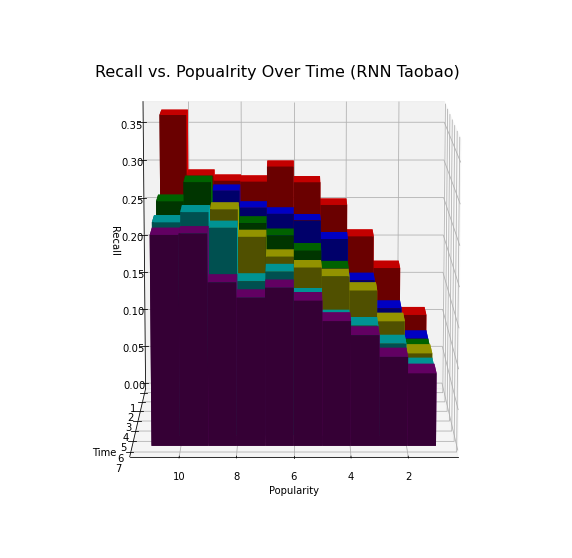

In [43]:
fig_recall = plt.figure(figsize=(10,10))
fig_recall.suptitle('Recall vs. Popualrity Over Time (RNN Taobao)', fontsize=16, y=.8)
ax = fig_recall.add_subplot(111, projection='3d')
x = [i for i in range(1, num_buckets + 1)]*num_times
repeat = [t for t in range(1,  num_times + 1)]
y = [element for element in repeat for i in range(num_buckets)]
z = 0
dx = 1
dy = 1
dz = np.array([time_bucket_recall_dict[time][k] for time in repeat for k in range(1, num_buckets+1)])
c = ['r','b','g','y','c', 'purple']
cs = [color for color in c for i in range(num_buckets)]
ax.bar3d(x, y, z, dx, dy, dz, shade=True, color=cs)
ax.view_init(elev=10, azim=90)
ax.set_xlabel('Popularity')
ax.set_ylabel('Time', labelpad=10)
ax.set_zlabel('Recall', labelpad=10)
plt.show()

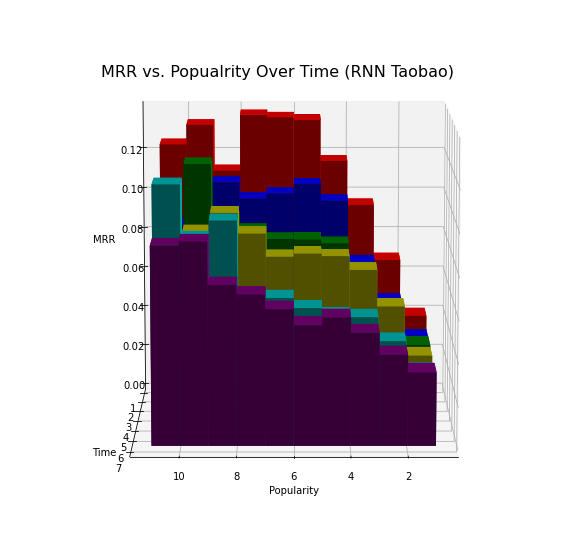

In [44]:
fig_mrr = plt.figure(figsize=(10,10))
fig_mrr.suptitle('MRR vs. Popualrity Over Time (RNN Taobao)', fontsize=16, y=.8)
ax = fig_mrr.add_subplot(111, projection='3d')
x = [i for i in range(1, num_buckets + 1)]*num_times
repeat = [t for t in range(1,  num_times + 1)]
y = [element for element in repeat for i in range(num_buckets)]
z = 0
dx = 1
dy = 1
dz = np.array([time_bucket_mrr_dict[time][k] for time in repeat for k in range(1, num_buckets+1)])
c = ['r','b','g','y','c', 'purple']
cs = [color for color in c for i in range(num_buckets)]
ax.bar3d(x, y, z, dx, dy, dz, shade=True, color=cs)
ax.view_init(elev=10, azim=90)
ax.set_xlabel('Popularity')
ax.set_ylabel('Time', labelpad=10)
ax.set_zlabel('MRR', labelpad=20)
plt.show()

In [45]:
pred_pop_dict = {}
for time in time_item_pred_dict.keys():
    for item in time_item_pred_dict[time]:
        if item in time_item_freq_dict[time]:
            pop = time_item_freq_dict[time][item]
            if pop not in pred_pop_dict:
                pred_pop_dict[pop] = []
            pred_pop_dict[pop].append(len(time_item_pred_dict[time][item]))
            
for pop, num_pred in pred_pop_dict.items():
    pred_pop_dict[pop] = np.mean(num_pred)

ordered_pop_pred = collections.OrderedDict(sorted(pred_pop_dict.items()))
print(ordered_pop_pred)

OrderedDict([(1.0, 11.436222252209703), (2.0, 13.778550599416784), (3.0, 16.090452969529554), (4.0, 19.45116804822909), (5.0, 21.56793870341808), (6.0, 25.065073553028842), (7.0, 28.09866711375639), (8.0, 31.725378186819), (9.0, 36.02587011601547), (10.0, 39.41402676605116), (11.0, 44.52865840856603), (12.0, 50.97845048742945), (13.0, 56.101605929586164), (14.0, 60.38450654403962), (15.0, 62.72798165137615), (16.0, 70.69665167416292), (17.0, 77.8483556638246), (18.0, 76.74330042313117), (19.0, 88.5267924528302), (20.0, 92.92336802270577), (21.0, 92.81052631578947), (22.0, 100.8236074270557), (23.0, 111.43723554301833), (24.0, 116.2877358490566), (25.0, 123.125), (26.0, 142.06042884990254), (27.0, 134.05353319057815), (28.0, 159.4070796460177), (29.0, 162.25130890052355), (30.0, 140.71693121693121), (31.0, 159.25076452599387), (32.0, 168.38741721854305), (33.0, 197.55555555555554), (34.0, 184.9517543859649), (35.0, 219.5279187817259), (36.0, 189.55825242718447), (37.0, 156.6379310344827

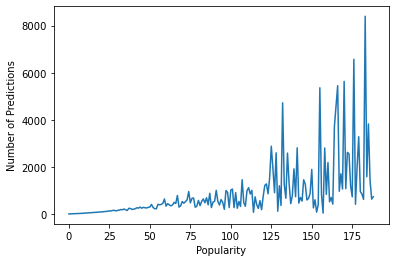

In [46]:
plt.plot(list(ordered_pop_pred.values()))
plt.ylabel('Number of Predictions')
plt.xlabel('Popularity')
plt.show()

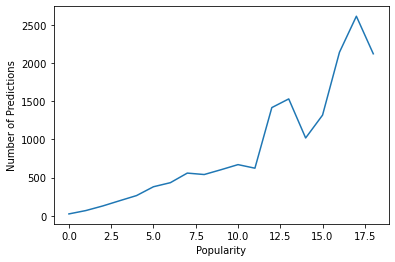

In [47]:
pop_pred_bucket_dict = {}
for num, num_pred in enumerate(ordered_pop_pred.values()):
    bucketid = num // 10
    if bucketid not in pop_pred_bucket_dict:
        pop_pred_bucket_dict[bucketid] = []
    pop_pred_bucket_dict[bucketid].append(num_pred)

for bucket, num_preds in pop_pred_bucket_dict.items():
    pop_pred_bucket_dict[bucket] = np.mean(num_preds)

plt.plot(list(pop_pred_bucket_dict.values()))
plt.ylabel('Number of Predictions')
plt.xlabel('Popularity')
plt.show()

In [48]:
recalls_pop_bucket = np.array([[time_bucket_recall_dict[time][k] for time in repeat] for k in range(1, num_buckets+1)])
mrrs_pop_bucket = np.array([[time_bucket_mrr_dict[time][k] for time in repeat] for k in range(1, num_buckets+1)])
print(recalls_pop_bucket)
print(mrrs_pop_bucket)

[[0.10790977 0.08763064 0.08742268 0.091464   0.08600079 0.08986346]
 [0.16981501 0.12735021 0.11283398 0.13211574 0.11505579 0.11003348]
 [0.2115116  0.16381034 0.15197551 0.1710477  0.13749819 0.13676296]
 [0.25249558 0.21713943 0.18890546 0.18852459 0.14675864 0.15402625]
 [0.28221314 0.24111102 0.21175008 0.1998947  0.17440029 0.17922349]
 [0.302677   0.2495743  0.23077471 0.21331725 0.20452629 0.19485399]
 [0.2830391  0.2574756  0.24667884 0.23825704 0.19273802 0.18273223]
 [0.28423008 0.27934917 0.25926417 0.27282141 0.25865775 0.20146743]
 [0.29088865 0.26184447 0.29858424 0.25474754 0.27803725 0.26083823]
 [0.36960784 0.25321271 0.27434471 0.25294412 0.26550147 0.25901961]]
[[0.0404345  0.03381426 0.03438179 0.03343374 0.03030093 0.03446553]
 [0.0683479  0.05176546 0.04667745 0.05715959 0.04468284 0.04261693]
 [0.09566042 0.07087317 0.06687768 0.07456531 0.05598383 0.05289718]
 [0.11739711 0.10091717 0.08351513 0.08093986 0.05685821 0.06001491]
 [0.13761884 0.10901338 0.0854760

[]

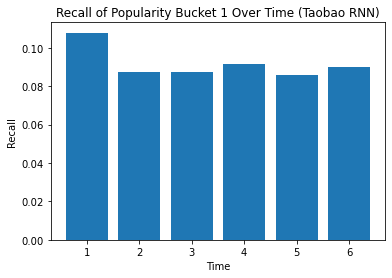

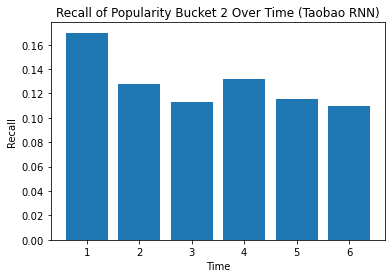

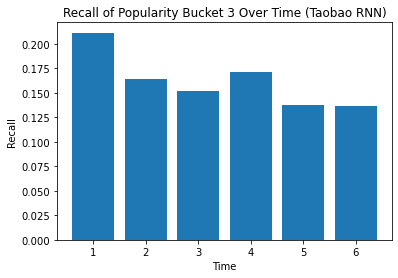

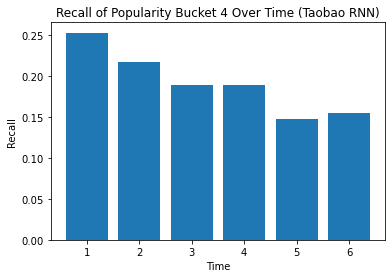

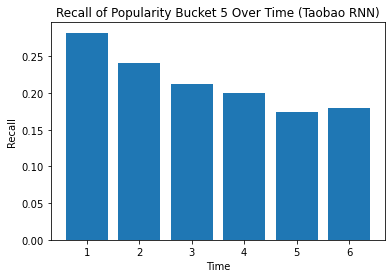

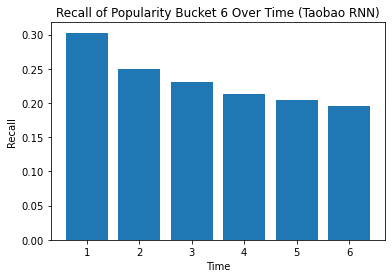

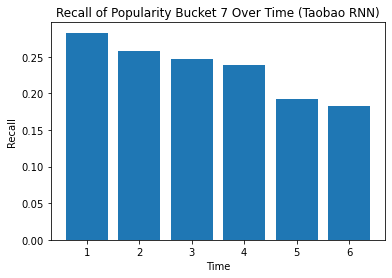

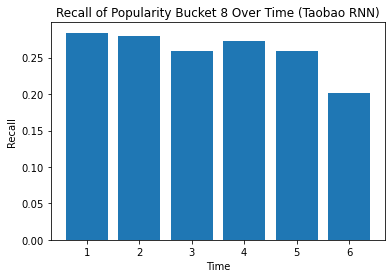

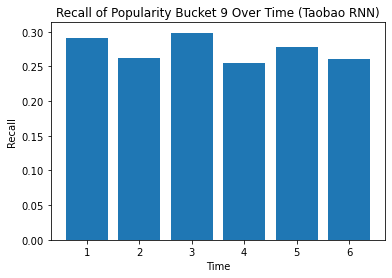

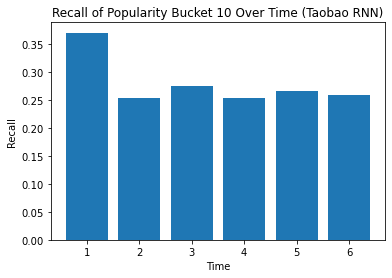

In [49]:
for bucket_num in range(num_buckets):
    plt.figure()
    plt.bar(np.arange(1, num_times+1), recalls_pop_bucket[bucket_num,:])
    plt.xlabel('Time')
    plt.ylabel('Recall')
    plt.title('Recall of Popularity Bucket %d Over Time (Taobao RNN)'%(bucket_num+1))
plt.plot()

[]

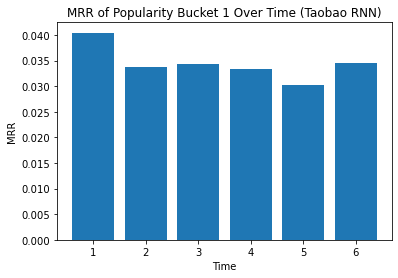

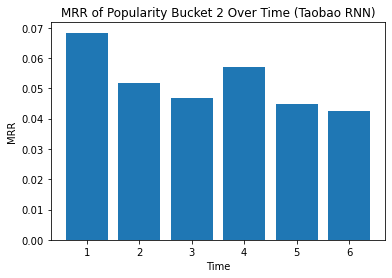

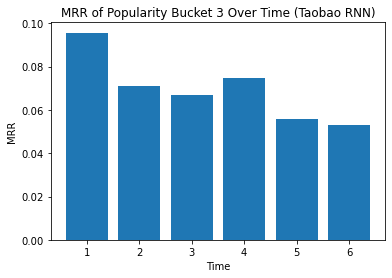

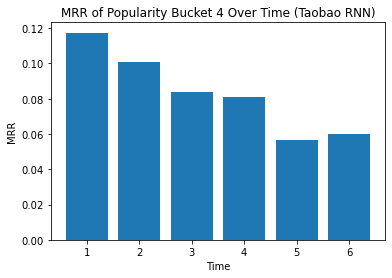

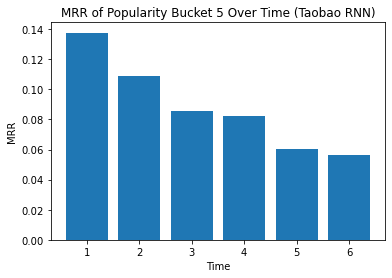

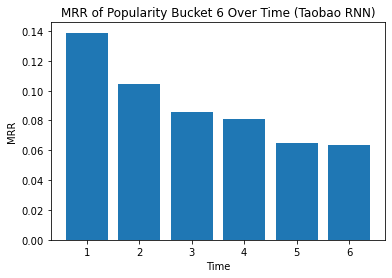

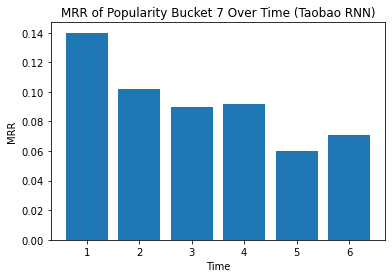

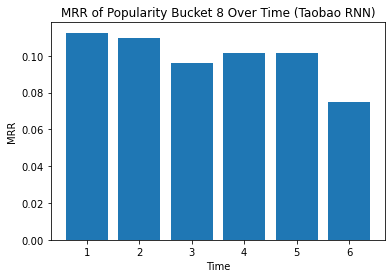

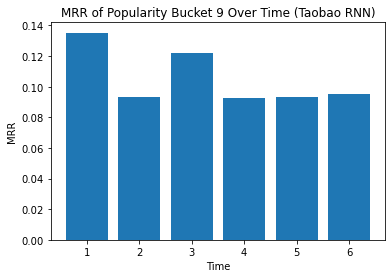

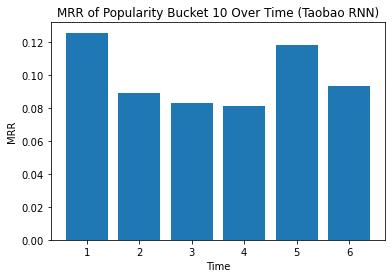

In [50]:
for bucket_num in range(num_buckets):
    plt.figure()
    plt.bar(np.arange(1, num_times+1), mrrs_pop_bucket[bucket_num,:])
    plt.xlabel('Time')
    plt.ylabel('MRR')
    plt.title('MRR of Popularity Bucket %d Over Time (Taobao RNN)'%(bucket_num+1))
plt.plot()

## Compare Probabilties of Items in Train and Test

In [57]:
item_freq_train = {}
item_freq_test = {}
item_pred_freq_test = {}
with torch.no_grad():
    
    for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
    y_action_batch, y_action_idx_batch, t_y_batch in train_data_loader:
        batch_size = y_action_batch.size(0)
        for seq_index in range(batch_size):
            y_i = y_action_batch[seq_index]
            t_i = t_y_batch[seq_index]
            item_i = y_i.item()
            for item in x_short_action_batch[seq_index]:
                item = item.item()
                if item not in item_freq_train:
                    item_freq_train[item] = 0.0
                item_freq_train[item] += 1.0
            if item_i not in item_freq_train:
                item_freq_train[item_i] = 0.0
            item_freq_train[item_i] += 1.0
            
    for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
    y_action_batch, y_action_idx_batch, t_y_batch in test_data_loader:
        for seq_index in range(batch_size):
            y_i = y_action_batch[seq_index]
            t_i = t_y_batch[seq_index]
            item_i = y_i.item()
            for item in x_short_action_batch[seq_index]:
                item = item.item()
                if item not in item_freq_test:
                    item_freq_test[item] = 0.0
                item_freq_test[item] += 1.0
            if item_i not in item_freq_test:
                item_freq_test[item_i] = 0.0
            item_freq_test[item_i] += 1.0
            
        x_short_action_batch = x_short_action_batch.to(device)
        mask_short_action_batch = mask_short_action_batch.to(device)
        y_action_batch = y_action_batch.to(device)

        # warm_start_mask = (y_action_idx_batch>=self.warm_start)

        output_batch = network(x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch)

        sampled_logit_batch, sampled_target_batch = network.m_ss(output_batch, y_action_batch, \
                                                    None, None, None, None, None, None, "full")

        _, preds = torch.topk(sampled_logit_batch, 1, -1)
        preds = preds.cpu()

        for seq_num in range(len(preds)):
            for pred in preds[seq_num]:
                item_id = pred.item()
                
                if item_id not in item_pred_freq_test:
                    item_pred_freq_test[item_id] = 0.0
                item_pred_freq_test[item_id] += 1.0

shuffling
shuffling


Finished Train
Finished Test


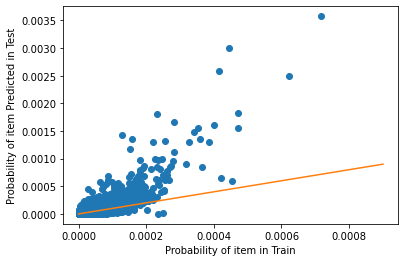

In [58]:
item_prob_train = {}
total_freq_train = np.sum(list(item_freq_train.values()))
for item, freq in item_freq_train.items():
    if item not in item_prob_train:
        item_prob_train[item] = 0.0
    item_prob_train[item] = freq / total_freq_train
print("Finished Train")

item_prob_test = {}
total_freq_test = np.sum(list(item_freq_test.values()))
for item, freq in item_freq_test.items():
    if item not in item_prob_test:
        item_prob_test[item] = 0.0
    item_prob_test[item] = freq / total_freq_test

pred_prob_test = {}
total_pred_test = np.sum(list(item_pred_freq_test.values()))
for item, freq in item_pred_freq_test.items():
    if item not in pred_prob_test:
        pred_prob_test[item] = 0.0
    pred_prob_test[item] = freq / total_pred_test
print("Finished Test")

sorted_train_probs = []
sorted_test_pred_probs = []
for item, freq in sorted(item_freq_train.items(), key = lambda kv:(kv[1], kv[0])):
    if item_prob_train[item] > .001:
        continue
    sorted_train_probs.append(item_prob_train[item])
    if item not in pred_prob_test:
        sorted_test_pred_probs.append(0)
    else:
        sorted_test_pred_probs.append(pred_prob_test[item])

sorted_train_probs = np.array(sorted_train_probs)
sorted_test_pred_probs = np.array(sorted_test_pred_probs)
x = np.array([i for i in np.arange(0, 0.001, 0.0001)])
y = np.array([i for i in np.arange(0, 0.001, 0.0001)])
plt.plot(sorted_train_probs, sorted_test_pred_probs, 'o')
plt.plot(x, y)
plt.xlabel('Probability of item in Train')
plt.ylabel('Probability of item Predicted in Test')
plt.show()

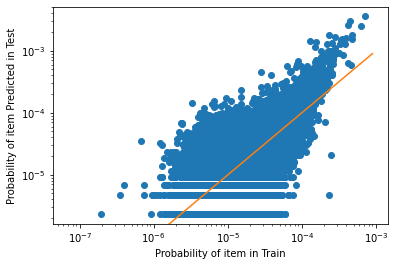

In [59]:
plt.plot(sorted_train_probs, sorted_test_pred_probs, 'o')
plt.plot(x, y)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Probability of item in Train')
plt.ylabel('Probability of item Predicted in Test')
plt.show()

In [60]:
total = len(sorted_train_probs)
above = [0 for i in range(8)] # num points above line
below = [0 for i in range(8)] # num points below line

range_test_prob = sorted_test_pred_probs[-1] - sorted_test_pred_probs[0]
for i in range(total):
    if above[0] == 0 and below[0] == 0:
        above[0] = [0 for x in range(5)]
        below[0] = [0 for x in range(5)]
    idx = int(sorted_train_probs[i] // 0.0001)
    
    y_dot = sorted_test_pred_probs[i]
    y_line = sorted_train_probs[i]
    
    if idx == 0:
        inner_idx = 0
        if sorted_train_probs[i] >= .000001 and sorted_train_probs[i] < .000005: inner_idx = 1
        elif sorted_train_probs[i] >= .000005 and sorted_train_probs[i] < .00001: inner_idx = 2
        elif sorted_train_probs[i] >= .00001 and sorted_train_probs[i] < .00005: inner_idx = 3
        elif sorted_train_probs[i] >= .00005 and sorted_train_probs[i] < .0001: inner_idx = 4
        
        if y_dot > y_line: above[0][inner_idx] += 1
        elif y_dot < y_line: below[0][inner_idx] += 1
            
    else:
        if y_dot > y_line: above[idx] += 1
        elif y_dot < y_line: below[idx] += 1
        
print("Number of Points:", total)
print("Ratios of Points Above and Below Line in Intervals")
print("[0.0000, 0.000001] = %d:%d"%(above[0][0], below[0][0]))
print("[0.000001, 0.000005] = %d:%d"%(above[0][1], below[0][1]))
print("[0.000005, 0.00001] = %d:%d"%(above[0][2], below[0][2]))
print("[0.00001, 0.00005] = %d:%d"%(above[0][3], below[0][3]))
print("[0.00005, 0.0001] = %d:%d"%(above[0][4], below[0][4]))
print("[0.0001, 0.0002] = %d:%d"%(above[1], below[1]))
print("[0.0002, 0.0003] = %d:%d"%(above[2], below[2]))
print("[0.0003, 0.0004] = %d:%d"%(above[3], below[3]))
print("[0.0004, 0.0005] = %d:%d"%(above[4], below[4]))
print("[0.0005, 0.0006] = %d:%d"%(above[5], below[5]))
print("[0.0006, 0.0007] = %d:%d"%(above[6], below[6]))
print("[0.0007, 0.0008] = %d:%d"%(above[7], below[7]))

Number of Points: 68007
Ratios of Points Above and Below Line in Intervals
[0.0000, 0.000001] = 8:15
[0.000001, 0.000005] = 3393:4542
[0.000005, 0.00001] = 11332:21622
[0.00001, 0.00005] = 9371:15923
[0.00005, 0.0001] = 753:664
[0.0001, 0.0002] = 248:78
[0.0002, 0.0003] = 39:3
[0.0003, 0.0004] = 7:0
[0.0004, 0.0005] = 7:0
[0.0005, 0.0006] = 0:0
[0.0006, 0.0007] = 1:0
[0.0007, 0.0008] = 1:0


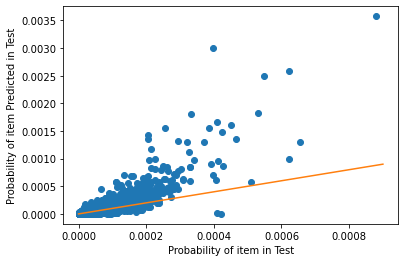

In [61]:
sorted_test_probs = []
sorted_test_pred_probs = [] # Different then above but same name due to same purpose
for item, freq in sorted(item_freq_test.items(), key = lambda kv:(kv[1], kv[0])):
    sorted_test_probs.append(item_prob_test[item])
    if item not in pred_prob_test:
        sorted_test_pred_probs.append(0)
    else:
        sorted_test_pred_probs.append(pred_prob_test[item])

sorted_test_probs = np.array(sorted_test_probs)
sorted_test_pred_probs = np.array(sorted_test_pred_probs)
plt.plot(sorted_test_probs, sorted_test_pred_probs, 'o')
plt.plot(x, y)
plt.xlabel('Probability of item in Test')
plt.ylabel('Probability of item Predicted in Test')
plt.show()

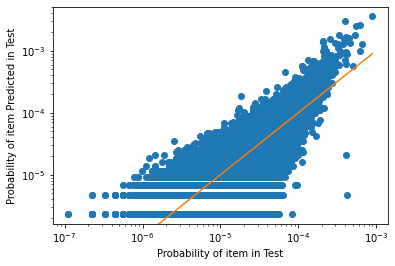

In [62]:
plt.plot(sorted_test_probs, sorted_test_pred_probs, 'o')
plt.plot(x, y)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Probability of item in Test')
plt.ylabel('Probability of item Predicted in Test')
plt.show()

In [63]:
total = len(sorted_test_probs)
above = [0 for i in range(9)] # num points above line
below = [0 for i in range(9)] # num points below line

range_test_prob = sorted_test_pred_probs[-1] - sorted_test_pred_probs[0]
for i in range(total):
    if above[0] == 0 and below[0] == 0:
        above[0] = [0 for x in range(5)]
        below[0] = [0 for x in range(5)]
    idx = int(sorted_test_probs[i] // 0.0001)
    
    y_dot = sorted_test_pred_probs[i]
    y_line = sorted_test_probs[i]
    
    if idx == 0:
        inner_idx = 0
        if sorted_test_probs[i] >= .000001 and sorted_test_probs[i] < .000005: inner_idx = 1
        elif sorted_test_probs[i] >= .000005 and sorted_test_probs[i] < .00001: inner_idx = 2
        elif sorted_test_probs[i] >= .00001 and sorted_test_probs[i] < .00005: inner_idx = 3
        elif sorted_test_probs[i] >= .00005 and sorted_test_probs[i] < .0001: inner_idx = 4
        
        if y_dot > y_line: above[0][inner_idx] += 1
        elif y_dot < y_line: below[0][inner_idx] += 1
            
    else:
        if y_dot > y_line: above[idx] += 1
        elif y_dot < y_line: below[idx] += 1
        
print("Number of Points:", total)
print("Ratios of Points Above and Below Line in Intervals")
print("[0.0000, 0.000001] = %d:%d"%(above[0][0], below[0][0]))
print("[0.000001, 0.000005] = %d:%d"%(above[0][1], below[0][1]))
print("[0.000005, 0.00001] = %d:%d"%(above[0][2], below[0][2]))
print("[0.00001, 0.00005] = %d:%d"%(above[0][3], below[0][3]))
print("[0.00005, 0.0001] = %d:%d"%(above[0][4], below[0][4]))
print("[0.0001, 0.0002] = %d:%d"%(above[1], below[1]))
print("[0.0002, 0.0003] = %d:%d"%(above[2], below[2]))
print("[0.0003, 0.0004] = %d:%d"%(above[3], below[3]))
print("[0.0004, 0.0005] = %d:%d"%(above[4], below[4]))
print("[0.0005, 0.0006] = %d:%d"%(above[5], below[5]))
print("[0.0006, 0.0007] = %d:%d"%(above[6], below[6]))
print("[0.0007, 0.0008] = %d:%d"%(above[7], below[7]))
print("[0.0008, 0.0009] = %d:%d"%(above[8], below[8]))

Number of Points: 67826
Ratios of Points Above and Below Line in Intervals
[0.0000, 0.000001] = 180:1171
[0.000001, 0.000005] = 4151:10334
[0.000005, 0.00001] = 6466:13605
[0.00001, 0.00005] = 11007:17970
[0.00005, 0.0001] = 874:1141
[0.0001, 0.0002] = 329:173
[0.0002, 0.0003] = 74:6
[0.0003, 0.0004] = 15:0
[0.0004, 0.0005] = 7:2
[0.0005, 0.0006] = 3:0
[0.0006, 0.0007] = 3:0
[0.0007, 0.0008] = 0:0
[0.0008, 0.0009] = 1:0
